실제 음식점에서의 질의를와 claude가 생성한 답변의 유사도를 word2vec모델을 학습하여 각 답변의 벡터를 구하고, cosine유사도로 결과를 정량적으로 비교한다.

# 데이터 처리 및 claude 사용 준비
ai hub의 소상공인 고객응대 데이터셋(https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=data&dataSetSn=102)의 validation_음식점.csv를 이용하여 음식점에서의 질의를 담은 데이터를 정리하고,

claude sonnet의 사용을 준비한다.

## 데이터 정리

In [ ]:
csvFile = "/content/음식점.csv"

In [ ]:
import csv

fields = []
rows = []
# reading csv file
with open(csvFile, 'r') as csvfile:
    # creating a csv reader object
    csvreader = csv.reader(csvfile)

    # extracting field names through first row
    fields = next(csvreader)

    # extracting each data row one by one
    for row in csvreader:
        rows.append(row)

    # get total number of rows
    print("Total no. of rows: %d" % (csvreader.line_num))

# printing the field names
print('Field names are:' + ', '.join(field for field in fields))

# printing first 5 rows
print('\nFirst 5 rows are:\n')
for row in rows[:5]:
    # parsing each column of a row
    for col in row:
        print("%10s" % col, end=" "),
    print('\n')

Total no. of rows: 32826
Field names are:﻿IDX, 발화자, 발화문, 카테고리, QA번호, QA여부, 감성, 인텐트, 가격, 수량, 크기, 장소, 조직, 사람, 시간, 날짜, 상품명, 상담번호, 상담내순번

First 5 rows are:

         1          c 방금 전에 주문한 사워크림고로케 2개 취소되었습니까?        음식점       2273          q          m   주문_취소_확인                    2개                                                                      사워크림고로케       2273          1 

         2          s 네, 방금 전에 주문하신 사워크림고로케 2개는 취소된 상태입니다.        음식점       2273          a          m   주문_취소_확인                    2개                                                                      사워크림고로케       2273          2 

         3          c 함박스테이크 두 개 다 취소된 거 맞아요?        음식점      28973          q          m   주문_취소_확인                   두 개                                                                       함박스테이크      28973          1 

         4          s 네, 함박스테이크 두 개 다 취소해 드렸습니다.        음식점      28973          a          m   주문_취소_확인                   두 개                               

In [ ]:
rows[0][2]

'방금 전에 주문한 사워크림고로케 2개 취소되었습니까?'

In [ ]:
raw_data = []
label_data = []
for row in rows:
  if row[1] == 'c':
    raw_data.append((row[17],row[2]))
  elif row[1] == 's':
    label_data.append((row[17],row[2]))

print(raw_data[0])
print(label_data[0])

raw_data.sort(key = lambda x: x[0])
label_data.sort(key = lambda x: x[0])

print(raw_data[0])
print(label_data[0])
print(raw_data[1])
print(label_data[1])
print(raw_data[2])
print(label_data[2])

('2273', '방금 전에 주문한 사워크림고로케 2개 취소되었습니까?')
('2273', '네, 방금 전에 주문하신 사워크림고로케 2개는 취소된 상태입니다.')
('1', '카드번호 부를까요?')
('1', '주문번호 알고계신가요?')
('10', '후추 좀 많이 넣어주세요.')
('10', '네, 알겠습니다.')
('100', '위스키 발렌타인 지금 있나요?')
('100', '네, 위스키 발렌타인 있습니다.')


In [ ]:
data = {'raw':[],'label':[]}
for raw in raw_data:
  for label in label_data:
    if raw[0] == label[0]:
      data['raw'].append(raw[1])
      data['label'].append(label[1])
      break
    elif raw[0] < label[0]:
      break
    else:
      del label_data[0]

print(data['raw'][0])
print(data['label'][0])

print(len(data['raw']))
print(len(data['label']))

카드번호 부를까요?
주문번호 알고계신가요?
9161
9161


In [ ]:
import pickle

with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

## claude sonnet 사용 세팅

In [ ]:
!pip install anthropic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.6/285.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.4 MB/s eta 0:00:00


In [ ]:
import anthropic
client = anthropic.Anthropic(api_key = "api_key를 입력해주세요")

def claude(query):
  message = client.messages.create(
            model="claude-3-sonnet-20240229",
            max_tokens=1024,
            system = "너는 식당의 점원이야. 이제부터 손님의 질문에 친절하게 응대해줘. 대답은 최대한 간결하고 짧게해줘",
            messages= [
                {
                    "role": "user",
                    "content": query
                }
            ]
        )

  return message.content[0].text

In [ ]:
print(rows[0][2])
print(rows[1][2])
print(claude(rows[0][2]))

방금 전에 주문한 사워크림고로케 2개 취소되었습니까?
네, 방금 전에 주문하신 사워크림고로케 2개는 취소된 상태입니다.
네, 주문하신 사워크림고로케 2개가 취소되었습니다.


## claude 결과 저장

In [ ]:
from tqdm import tqdm

model_result = []
for raw in tqdm(data['raw'][:3000]):
  model_result.append(claude(raw))

100%|██████████| 3000/3000 [1:30:17<00:00,  1.81s/it]


In [ ]:
import pickle

with open('/content/drive/MyDrive/dataK/model_result.pkl', 'wb') as f:
    pickle.dump(model_result, f)

# 데이터 load
사용한 소상공인 고객응대 데이터셋와 claude를 거쳐서 나온 결과를 저장한 데이터를 load

대상파일명 : data.pkl , model_result.pkl

In [ ]:
import pickle

data = pickle.load(open('/content/data.pkl','rb'))
model_result = pickle.load(open('/content/model_result.pkl','rb'))

# word2vec 한국어
위의 데이터들(claude의 답변과 사용한 데이터의 질문과 답변)을 이용해서 mecab으로 토크나이징 후 word2vec모델에 학습하여 이용예정

저장할 모델명 : kor_w2v

In [ ]:
!pip install konlpy
!pip install python-mecab-ko

In [ ]:
from mecab import MeCab as mecab

# Mecab 로드 (또는 다른 형태소 분석기 사용 가능)
mecab = mecab()
word2vecTrain =  [mecab.morphs(sentence) for sentence in data['raw']]+[mecab.morphs(sentence) for sentence in data['label']]+[mecab.morphs(sentence) for sentence in model_result]

stop_words = set([
    "이", "는", "을", "있", "것", "있다", "수", "등", "의", "이다", "들", "그", "에서", "하다"
])

word2vecTrain =[[word for word in words if word not in stop_words] for words in word2vecTrain  ]

In [ ]:
len(word2vecTrain)

21322

In [ ]:
!pip install gensim

In [ ]:
word2vecTrain[:3]

[['카드', '번호', '부를까요', '?'],
 ['참이슬', '도', '한', '병', '부탁', '드립니다', '.'],
 ['기본', '세팅', '과자', '안', '주', '셔도', '돼요', '.']]

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=word2vecTrain, vector_size=100, window=5, min_count=1, workers=4)

from gensim.models import KeyedVectors

model.wv.save_word2vec_format('kor_w2v') # 모델 저장

# 비교
mecab을 통해 토크나이징한 문장 실제 대답데이터와 claude가 생성한 대답데이터를 위에서 학습한 모델로 벡터화하여 cosine 유사도를 구한다.

In [112]:
import numpy as np
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from gensim.test.utils import datapath
from mecab import MeCab as mecab

model = KeyedVectors.load_word2vec_format("kor_w2v") # 모델 로드

# Mecab 로드 (또는 다른 형태소 분석기 사용 가능)
mecab = mecab()

# 문장 토큰화 및 임베딩 벡터 변환 함수
def sentence_to_vec(sentence, model):
    words = mecab.morphs(sentence)  # 형태소 분석기로 토큰화
    word_vecs = []

    for word in words:
        if word in model:
            word_vecs.append(model[word])

    if len(word_vecs) == 0:  # 만약 문장의 모든 단어가 모델에 없는 경우
        return np.zeros(model.vector_size)

    # 문장의 임베딩 벡터는 단어 벡터의 평균으로 계산
    sentence_vec = np.mean(word_vecs, axis=0)
    return sentence_vec

# cosine 유사도 계산 함수
def cosine_similarity_vec(vec1, vec2):
    vec1 = vec1.reshape(1, -1)
    vec2 = vec2.reshape(1, -1)
    return cosine_similarity(vec1, vec2)[0][0]


# test
# 두 문장 예제
sentence1 = "오늘 날씨가 좋다."
sentence2 = "날씨가 매우 맑다."

# 문장을 임베딩 벡터로 변환
vec1 = sentence_to_vec(sentence1, model)
vec2 = sentence_to_vec(sentence2, model)

# cosine 유사도 계산
similarity = cosine_similarity_vec(vec1, vec2)
print(f"Cosine 유사도: {similarity}")

Cosine 유사도: 0.9586980938911438


In [113]:
resultGraph = [0] * 101
print(type(resultGraph))

<class 'list'>


In [114]:
sum = 0
for num in range(len(model_result)):
  vec1 = sentence_to_vec(data['label'][num], model)
  vec2 = sentence_to_vec(model_result[num], model)

  similarity = cosine_similarity_vec(vec1, vec2)
  # print(f"Cosine 유사도: {similarity}")

  sum += similarity

  resultGraph[int(similarity//0.01)] += 1


In [ ]:
print('평균 유사도:',sum/len(model_result))

평균 유사도: 0.8312343618174394


In [ ]:
import pickle

with open('result.pkl', 'wb') as f:
    pickle.dump(resultGraph, f)

# 시각화
실제 라벨과 claude를 통해 생성한 답변의 유사도를 시각화 하였다.

코사인 유사도의 범위에 따라 정리한 데이터량 : result.pkl

In [ ]:
import pickle

resultGraph = pickle.load(open('result.pkl','rb'))

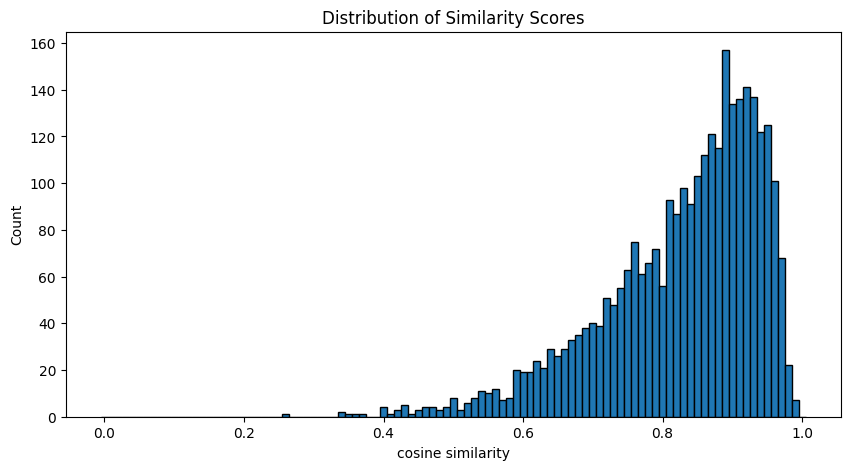

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

# 그래프 그리기
plt.bar(np.arange(0,1.01,0.01), resultGraph, width=0.01, edgecolor='black')



# 그래프 제목 및 축 레이블 추가
plt.title('Distribution of Similarity Scores')
plt.xlabel('cosine similarity')
plt.ylabel('Count')

# 그래프 표시
plt.show()

위 결과를 통해 대부분의 대답들이 실제 답변과 매우 높은 유사성을 보여준다.